# MCMC with PyStan

In [1]:
#packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
print(pystan.__version__)

2.19.1.1


## Import data

In [2]:
trainDat = pd.read_csv('../thesis/data/trainData.csv')
validDat = pd.read_csv('../thesis/data/validationData.csv')
testDat = pd.read_csv('../thesis/data/testData.csv')
print (trainDat.shape,validDat.shape,testDat.shape)

(21200, 3) (5300, 3) (6626, 3)


In [3]:
x_train =trainDat["standAge"]
x_valid =validDat["standAge"]
x_test =testDat["standAge"]

In [5]:
y_train = trainDat['target']
y_valid = validDat["target"]
y_test = testDat['target']
print(y_train.shape, y_valid.shape, y_test.shape)

(21200,) (5300,) (6626,)


## Functions

In [58]:
def plot_trace(param, param_name='parameter'):

  
    ##mean, 95% CI
    mean = np.mean(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

  
    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param, color ="tab:blue")
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='k', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='black', alpha=0.5)
    plt.axhline(cred_max, linestyle=':', color='black', alpha=0.5)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    sns.kdeplot(data=param, shade=True,palette="mako")
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='k', lw=2, linestyle='--',label='mean')
    plt.axvline(cred_min, lw=2, linestyle=':', color='black', alpha=1.0, label='95% CI')
    plt.axvline(cred_max, lw=2, linestyle=':', color='black', alpha=1.0)


    plt.legend()

### Logistic Regression

In [52]:
x_trainLR =  x_train.values.reshape(-1, 1)
modelLog = LogisticRegression()
model = modelLog.fit(x_trainLR,y_train)
interceptLR = model.intercept_

## MCMC with fix intercept (solution from Logistic Regression)

In [53]:

melanom_data = {'N': x_trainLR.shape[0], 'M': x_trainLR.shape[1], 'X': x_trainLR, 'y': y_train, 'intercept':interceptLR }

lr_code = """

  data {
    int N;
    int M;
    real X[N, M];
    int<lower=0, upper=1> y[N];
  }
  
  parameters {
    real beta[M]; 
    real intercept;
  }
  
model{
    for (i in 1:N)
        y[i] ~ bernoulli(inv_logit (intercept+ dot_product(X[i] , beta)));
    beta[M] ~ normal(0, 1);
   
  }
"""        


stm = pystan.StanModel(model_code=lr_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_876afae859b1ef2dd8189d1f219d798c NOW.


In [54]:
n_itr = 21000
n_warmup = 500
chains = 3

fit = stm.sampling(data=melanom_data, iter=n_itr, chains=chains, n_jobs=-1, 
                   warmup=n_warmup, algorithm="NUTS", verbose=False)

In [55]:
fit

Inference for Stan model: anon_model_876afae859b1ef2dd8189d1f219d798c.
3 chains, each with iter=21000; warmup=500; thin=1; 
post-warmup draws per chain=20500, total post-warmup draws=61500.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]      0.7  3.4e-4   0.05    0.6   0.67    0.7   0.74   0.81  24917    1.0
intercept  -4.25  4.0e-4   0.06  -4.38  -4.29  -4.25  -4.21  -4.13  24649    1.0
lp__       -1804  6.2e-3    1.0  -1807  -1804  -1804  -1803  -1803  26096    1.0

Samples were drawn using NUTS at Fri Oct  8 14:24:25 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

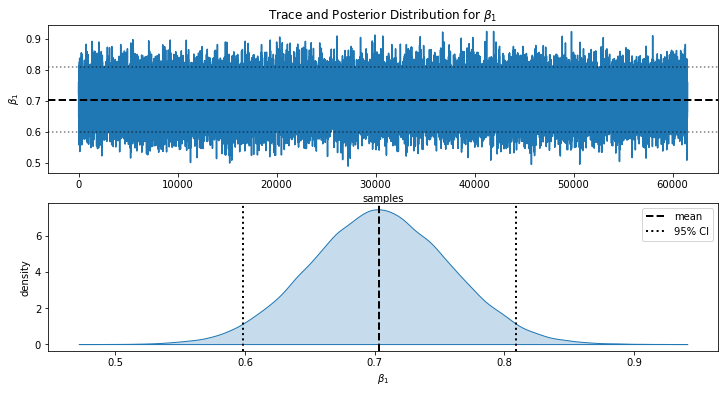

In [63]:
plt.figure(figsize=(12,6))
plot_trace(fit.extract()['beta'][:,0],"$\\beta_1$")

In [ ]:
##Extract Mean Value slope
meanSlope = np.mean(fit.extract()['beta'][:,0])
meanSlope

## MCMC with intercept and slope

In [65]:

melanom_data = {'N': x_trainLR.shape[0], 'M': x_trainLR.shape[1], 'X': x_trainLR, 'y': y_train}

lr_code = """

  data {
    int N;
    int M;
    real X[N, M];
    int<lower=0, upper=1> y[N];
  }
  
  parameters {
    real beta[M];
    real beta0; 
  }
  
  
  model {
    for (i in 1:N)
        y[i] ~ bernoulli(inv_logit (beta0 + dot_product(X[i] , beta)));
    beta[M] ~ normal(0, 1);
    beta0 ~ normal(0, 1);
  }
"""        


stm = pystan.StanModel(model_code=lr_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a751f024d794960b55f579df10f5570a NOW.


In [66]:
n_itr = 21000
n_warmup = 500
chains = 3

fit4 = stm.sampling(data=melanom_data, iter=n_itr, chains=chains, n_jobs=-1, 
                   warmup=n_warmup, algorithm="NUTS", verbose=False)

In [67]:
fit4

Inference for Stan model: anon_model_a751f024d794960b55f579df10f5570a.
3 chains, each with iter=21000; warmup=500; thin=1; 
post-warmup draws per chain=20500, total post-warmup draws=61500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]    0.7  3.4e-4   0.05   0.59   0.66    0.7   0.73    0.8  24889    1.0
beta0    -4.24  4.1e-4   0.06  -4.36  -4.28  -4.23  -4.19  -4.11  24455    1.0
lp__     -1813  6.2e-3    1.0  -1816  -1813  -1813  -1812  -1812  25824    1.0

Samples were drawn using NUTS at Fri Oct  8 14:33:34 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

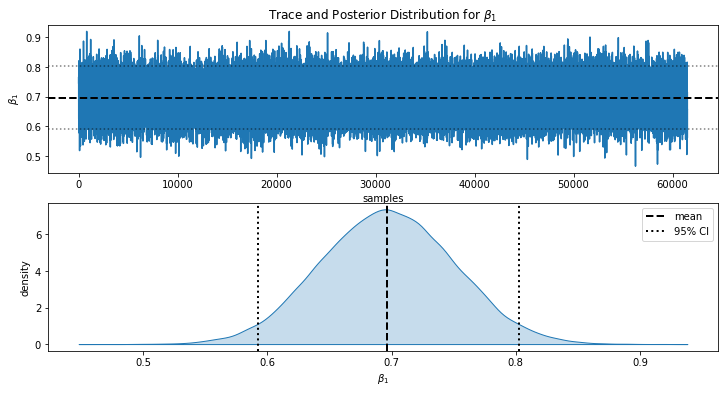

In [68]:
plt.figure(figsize=(12,6))
plot_trace(fit4.extract()['beta'][:,0],"$\\beta_1$")

In [71]:
##Extract Mean Value slope
meanSlope = np.mean(fit4.extract()['beta'][:,0])
##Extract Mean Value intercept
meanIntercept = np.mean(fit4.extract()['beta0'])
meanSlope, meanIntercept

(0.6965755354752582, -4.235263609883572)